In [2]:
%%time
"""
Importing Modules
"""

import pickle, sys, os
import numpy as np
from matplotlib import pyplot as plt

sys.path.append(os.path.realpath('/run/user/1000/gvfs/sftp:host=newton,user=skhodadadeh/home/skhodadadeh/MFG-MARL-IPP/'))

# sys.path.append(os.path.realpath('../MFG-MARL-IPP'))
from visuals.video_generation.visualization import Visualization
from visuals.visual_results import data_from_exp

CPU times: user 1.73 ms, sys: 371 µs, total: 2.1 ms
Wall time: 147 ms


In [3]:
%%time
"""
Base Constants 
"""

BUDGET_PERCENT = True
QUEUE_PERCENT = False
PUNISHMENT = False
TELEPORT_INCLUDED = True

BASE_DIR = "/run/user/1000/gvfs/sftp:host=newton,user=skhodadadeh/home/skhodadadeh/MFG-MARL-IPP/data/"
# BASE_DIR = "data/"
CURRENT_FILE_NAME = "_outputs/mixed_variables/scenario.0.1614614987.5974162/pickle.pkl"

COMPUTE_AGENT_AVERAGE = False

METRIC_OF_INTEREST = 0
interesting_metrics = [ ('mut-dia', "Mutual-Information (nats)"), ('rsme', "Root Mean Square Error (unit)"), ('exe_tim', "Execution Time (seconds)") ]

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.4 µs


In [4]:
%%time
"""
Derived Constants 
"""
INPUT_DIR = BASE_DIR + "_inputs/"
OUTPUT_DIR = BASE_DIR + "_outputs/"

FOCUSED_INPUT_DIR = INPUT_DIR + CURRENT_FILE_NAME
FOCUSED_OUTPUT_DIR = OUTPUT_DIR + CURRENT_FILE_NAME

BUDGET_DIR = FOCUSED_INPUT_DIR + "budget_percent/"
QUEUE_DIR = FOCUSED_INPUT_DIR + "queue_percent/"
PUNISH_DIR = FOCUSED_INPUT_DIR + "punishment/"

METRIC_KEY = interesting_metrics[METRIC_OF_INTEREST][0]
METRIC_NAME = ("Agent-Average " + interesting_metrics[METRIC_OF_INTEREST][1]) if COMPUTE_AGENT_AVERAGE else ("Total " + interesting_metrics[METRIC_OF_INTEREST][1])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.34 µs


In [5]:
%%time
"""
Functions
"""

#importing pickle data when directory is formatted as "{variable}/{value}/agent_num={agent number}/{pickle name}.pkl"
def get_results(var_directory):
    results = {}
    with os.scandir(var_directory) as var_entries:
        for var_entry in var_entries:
            current_value = var_entry.name
            val_directory = var_directory + f"{var_entry.name}/"
            
            with os.scandir(val_directory) as val_entries:
                for val_entry in val_entries:
                    current_agent_number = val_entry.name[10:]
                    agent_directory = val_directory + f"{val_entry.name}/"
                    
                    with os.scandir(agent_directory) as agent_entries:
                        for agent_entry in agent_entries:                             
                            if ".pkl" in agent_entry.name:
                                results_directory = agent_directory + agent_entry.name
                                
                                with open(results_directory, 'rb') as file:
                                    
                                    if current_value not in results:
                                        results[current_value] = {}
                                    
                                    if current_agent_number not in results[current_value]:
                                        results[current_value][current_agent_number] = []
                                    
                                    pickle_content = pickle.load(file)
                                    results[current_value][current_agent_number].append(pickle_content)
    return results


def compute_averages(all_results, desired_metrics, method, agent_average=False, max_metric_to_follow=None):
    averages = {}
    
    for val in all_results:
        for agent_num in all_results[val]:
            for metric in desired_metrics:
                for result in all_results[val][agent_num]:
                    
                    if val not in averages:
                        averages[val] = {}

                    if agent_num not in averages[val]:
                        averages[val][agent_num] = {}

                    if metric not in averages[val][agent_num]:
                        averages[val][agent_num][metric] = 0.0
                    
                    epi = None
                    
                    if method == 'model':
                        if max_metric_to_follow is None:
                            training_results = result['all_measurements'][metric][:result['all_params']['tra_params']['episodes']]
                            epi = training_results.index(np.max(training_results))
                        else:
                            training_results = result['all_measurements'][max_metric_to_follow][:result['all_params']['tra_params']['episodes']]
                            epi = training_results.index(np.max(training_results))

                    else:
                        epi = result['relevant_testing_results']["standard_starts"][method]['epi']
                        
                    
                    divisor = 1
                    if agent_average:
                        divisor = float(agent_num)
                        
                    averages[val][agent_num][metric] = averages[val][agent_num][metric] + result['all_measurements'][metric][epi] / len(all_results[val][agent_num]) / divisor                       
                    print(('val', val), ('actual_agent_num', result['all_params']['sim_params']['agent_num']), ('method', method), ('meas', result['all_measurements'][metric][epi]))
    return averages

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.78 µs


In [6]:
%%time
"""
Importing Pickle Data
"""

budget_results = None
queue_results = None
punish_results = None

if BUDGET_PERCENT:
    budget_results = get_results(BUDGET_DIR)
    
if QUEUE_PERCENT:
    queue_results = get_results(QUEUE_DIR)

if PUNISHMENT:
    punish_results = get_results(PUNISH_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '/run/user/1000/gvfs/sftp:host=newton,user=skhodadadeh/home/skhodadadeh/MFG-MARL-IPP/data/_inputs/Wave_3/budget_percent/'

In [7]:
%%time
"""
Computing Best-Training, Greedy and Random Averages
"""

budget_averages = None
queue_averages = None
punish_averages = None

averages_to_compute = []
for info in interesting_metrics[:1]:
    averages_to_compute.append(info[0])


if BUDGET_PERCENT:
    budget_averages = {}
    budget_averages['model'] = compute_averages(budget_results, averages_to_compute, 'model', agent_average=COMPUTE_AGENT_AVERAGE, max_metric_to_follow='mut-dia')
    budget_averages['greedy'] = compute_averages(budget_results, averages_to_compute, 'greedy', agent_average=COMPUTE_AGENT_AVERAGE)
    budget_averages['random'] = compute_averages(budget_results, averages_to_compute, 'random', agent_average=COMPUTE_AGENT_AVERAGE)
    
if QUEUE_PERCENT:
    queue_averages = {}
    queue_averages['model'] = compute_averages(queue_results, averages_to_compute, 'model', agent_average=COMPUTE_AGENT_AVERAGE, max_metric_to_follow='mut-dia')
    queue_averages['greedy'] = compute_averages(queue_results, averages_to_compute, 'greedy', agent_average=COMPUTE_AGENT_AVERAGE)
    queue_averages['random'] = compute_averages(queue_results, averages_to_compute, 'random', agent_average=COMPUTE_AGENT_AVERAGE)

if PUNISHMENT:
    punish_averages = {}
    punish_averages['model'] = compute_averages(punish_results, averages_to_compute, 'model', agent_average=COMPUTE_AGENT_AVERAGE, max_metric_to_follow='mut-dia')
    punish_averages['greedy'] = compute_averages(punish_results, averages_to_compute, 'greedy', agent_average=COMPUTE_AGENT_AVERAGE)
    punish_averages['random'] = compute_averages(punish_results, averages_to_compute, 'random', agent_average=COMPUTE_AGENT_AVERAGE)

TypeError: 'NoneType' object is not iterable

In [8]:
%%time
"""
Number of Agents v. Metric
"""
if BUDGET_PERCENT:
    count = 0
    for val in budget_results:
        models = []
        labels = []
        agent_num_keys = [int(agent_num) for agent_num in budget_results[val]]
        agent_num_keys.sort()
        for agent_num in agent_num_keys:
            models.append(budget_averages['model'][val][str(agent_num)][METRIC_KEY])
            labels.append(agent_num)

        if count == 0:
            plt.plot(labels, models, linestyle='-', marker='X', color='b', label=f"B%={100*float(val)}%")
        else:
            plt.plot(labels, models, linestyle='-', marker='X', color='r', label=f"B%={100*float(val)}%")

        count = 1

    plt.ylabel(METRIC_NAME)
    plt.xlabel("Number of Agents")
    plt.legend()
    plt.show()

TypeError: 'NoneType' object is not iterable

In [9]:
%%time
"""
Number of Agents v. Exploration Method v. Metric
"""

if BUDGET_PERCENT:
    for val in budget_results:
        models = []
        greedys = []
        randoms = []
        labels = []
        agent_num_keys = [int(agent_num) for agent_num in budget_results[val]]
        agent_num_keys.sort()
        for agent_num in agent_num_keys:
            models.append(budget_averages['model'][val][str(agent_num)][METRIC_KEY])
            greedys.append(budget_averages['greedy'][val][str(agent_num)][METRIC_KEY])
            #randoms.append(budget_averages['random'][val][str(agent_num)][METRIC_KEY])
            labels.append(agent_num)

        print(models, greedys, randoms)

        bar_width = 0.25

        models_pos = np.arange(len(labels))
        greedys_pos = [x + bar_width for x in models_pos]
        #randoms_pos = [x + bar_width for x in greedys_pos]

        plt.bar(models_pos, models, color='#ff0000', width=bar_width, edgecolor='white', label='model')
        plt.bar(greedys_pos, greedys, color='#00ff00', width=bar_width, edgecolor='white', label='greedy')
        #plt.bar(randoms_pos, randoms, color='#0000ff', width=bar_width, edgecolor='white', label='random')

        plt.xlabel('Number of Agents')
        plt.ylabel(f"[B%={100*float(val)}] {METRIC_NAME}")
        plt.xticks([r + bar_width for r in range(len(models))], labels)

        plt.legend()
        plt.show()

TypeError: 'NoneType' object is not iterable

In [9]:
%%time
"""
Queue Percent v. Metric
"""
if QUEUE_PERCENT:
    models = []
    labels = []

    for val in queue_results:
        agent_num_keys = [int(agent_num) for agent_num in queue_results[val]]
        agent_num_keys.sort()
        for agent_num in agent_num_keys:
            models.append(queue_averages['model'][val][str(agent_num)][METRIC_KEY])
            labels.append(val)

    plt.plot(labels, models, linestyle='-', marker='X', color='b')
    plt.ylabel(f"[B%=50%] {METRIC_NAME}")
    plt.xlabel("Queue Percent")
    plt.show()

Wall time: 0 ns


In [10]:
%%time
"""
Generating Videos
"""

if BUDGET_PERCENT:
    budget_percent = '0.4'
     
    for method in budget_averages:
        for agent_num in budget_results[budget_percent]:
            export_directory = FOCUSED_OUTPUT_DIR + f"{method}/agent_num={agent_num}/"
            print("\n", method, agent_num)

            result = budget_results[budget_percent][agent_num][0]
            agent_exp = None
            if method == 'model':
                agent_exp = result['relevant_training_episodes']['hi_mut-dia']['exp']
            else:
                agent_exp = result['relevant_testing_results']['standard_starts'][method]['exp']

            paths, heats = data_from_exp(agent_exp, result['all_params'])
            world_dims = result['all_params']['sim_params']['world_dim']


            v = Visualization(moves=paths, groundTruth=[[0]*np.prod(world_dims)], heatmaps=[[]], exportDirectory=export_directory, 
                             suppressOutput=1, suppressVideo=0, datadisplayed=(), dimensions=world_dims, scale=7)
            v.visualize()


 model 10
Getting visualization...

error: Couldn't open data/_outputs/Wave_3/model/agent_num=10//frame0.png

<Figure size 432x288 with 0 Axes>

In [11]:
%%time
"""
Punishment v. Metric
"""

if PUNISHMENT:
    
    models = []
    greedys = []
    randoms = []
    labels = []
    keys = [float(key) for key in punish_results]
    keys.sort()
    for punish in keys:
        models.append(punish_averages['model'][str(punish)][str(3)][METRIC_KEY])
        greedys.append(punish_averages['greedy'][str(punish)][str(3)][METRIC_KEY])
        if punish == min(keys):
            randoms.append(0)#randoms.append(punish_averages['random'][punish][str(3)][METRIC_KEY])
        else:
            randoms.append(0)#randoms.append(punish_averages['random'][str(punish)][str(3)][METRIC_KEY])
        labels.append(punish)

    print(models, greedys, randoms)

    bar_width = 0.25

    models_pos = np.arange(len(labels))
    greedys_pos = [x + bar_width for x in models_pos]
    randoms_pos = [x + bar_width for x in greedys_pos]

    plt.bar(models_pos, models, color='#ff0000', width=bar_width, edgecolor='white', label='model')
    plt.bar(randoms_pos, randoms, color='#0000ff', width=bar_width, edgecolor='white', label='random')
    plt.bar(greedys_pos, greedys, color='#00ff00', width=bar_width, edgecolor='white', label='greedy')

    plt.xlabel('Punishment Value')
    plt.ylabel(f"[B%=40%] {METRIC_NAME}")
    plt.xticks([r + bar_width for r in range(len(models))], labels)

    plt.legend()
    plt.show()

Wall time: 0 ns


In [12]:
%%time
teleport_averages = None
teleport_results = None
if TELEPORT_INCLUDED:
    teleport_averages = {}
    teleport_results = {}
    teleport_results = get_results("data/_inputs/Wave_3.1/budget_percent/")
    teleport_averages['model'] = compute_averages(teleport_results, averages_to_compute, 'model', agent_average=COMPUTE_AGENT_AVERAGE, max_metric_to_follow='mut-dia')
    teleport_averages['greedy'] = compute_averages(teleport_results, averages_to_compute, 'greedy', agent_average=COMPUTE_AGENT_AVERAGE)
    teleport_averages['random'] = compute_averages(teleport_results, averages_to_compute, 'random', agent_average=COMPUTE_AGENT_AVERAGE)
    teleport_averages['bad_teleport'] = compute_averages(teleport_results, averages_to_compute, 'bad_teleport', agent_average=COMPUTE_AGENT_AVERAGE)
    teleport_averages['good_teleport'] = compute_averages(teleport_results, averages_to_compute, 'good_teleport', agent_average=COMPUTE_AGENT_AVERAGE)        

('val', '0.4') ('actual_agent_num', 3) ('method', 'model') ('meas', 2.0204681977299543)
('val', '0.4') ('actual_agent_num', 3) ('method', 'model') ('meas', 2.039506004374857)
('val', '0.4') ('actual_agent_num', 3) ('method', 'model') ('meas', 1.9856226912756938)
('val', '0.5') ('actual_agent_num', 3) ('method', 'model') ('meas', 1.56765454085172)
('val', '0.5') ('actual_agent_num', 3) ('method', 'model') ('meas', 1.5622766202027236)
('val', '0.4') ('actual_agent_num', 3) ('method', 'greedy') ('meas', 1.9471975820087266)
('val', '0.4') ('actual_agent_num', 3) ('method', 'greedy') ('meas', 1.906466620270308)
('val', '0.4') ('actual_agent_num', 3) ('method', 'greedy') ('meas', 1.8321032505224508)
('val', '0.5') ('actual_agent_num', 3) ('method', 'greedy') ('meas', 1.5277627991557665)
('val', '0.5') ('actual_agent_num', 3) ('method', 'greedy') ('meas', 1.537989431955566)
('val', '0.4') ('actual_agent_num', 3) ('method', 'random') ('meas', 1.0163628318453846)
('val', '0.4') ('actual_agent_n

[2.0151989644601684, 1.895255817600495, 2.129290557547847, 1.1691139034750506, 0.8811860367086504]


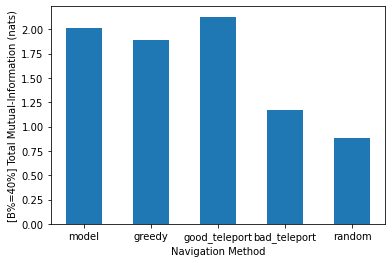

[1.5649655805272218, 1.5328761155556663, 2.1076607967399354, 1.1691139029332618, 0.8293777048362116]


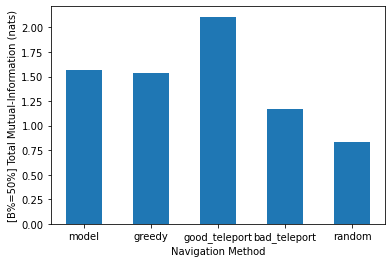

Wall time: 337 ms


In [13]:
%%time

if TELEPORT_INCLUDED:
    labels = ['model', 'greedy', 'good_teleport', 'bad_teleport', 'random']
    results4 = [teleport_averages[label][str(0.4)][str(3)][METRIC_KEY] for label in labels]
    results5 = [teleport_averages[label][str(0.5)][str(3)][METRIC_KEY] for label in labels]

    positions = np.arange(len(labels))
    positions = 1.5*positions

    print(results4)
    plt.bar(positions, results4)
    plt.xticks(positions, labels)
    plt.xlabel('Navigation Method')
    plt.ylabel(f"[B%=40%] {METRIC_NAME}")
    plt.show()

    print(results5)
    plt.bar(positions, results5)
    plt.xticks(positions, labels)
    plt.xlabel('Navigation Method')
    plt.ylabel(f"[B%=50%] {METRIC_NAME}")
    plt.show()

In [14]:
%%time
"""
Generating Videos
"""

if TELEPORT_INCLUDED:   
    for method in teleport_averages:
        for agent_num in teleport_averages[method]:
            if agent_num == '0.5':
                continue
            export_directory = "data/_outputs/Wave_3.1/" + f"{method}/agent_num={3}/"
            print("\n", method, agent_num)
            print(f"Output Directory: {export_directory}")
            result = teleport_results['0.4'][str(3)][0]
            agent_exp = None
            if method == 'model':
                agent_exp = result['relevant_training_episodes']['hi_mut-dia']['exp']
            else:
                agent_exp = result['relevant_testing_results']['standard_starts'][method]['exp']

            paths, heats = data_from_exp(agent_exp, result['all_params'])
            world_dims = result['all_params']['sim_params']['world_dim']


            v = Visualization(moves=paths, groundTruth=[[0]*np.prod(world_dims)], heatmaps=[[]], exportDirectory=export_directory, 
                             suppressOutput=1, suppressVideo=0, datadisplayed=(), dimensions=world_dims, scale=7)
            v.visualize()


 model 0.4
Output Directory: data/_outputs/Wave_3.1/model/agent_num=3/
Getting visualization...Saving output.
Getting coverage...Saving output.

 greedy 0.4
Output Directory: data/_outputs/Wave_3.1/greedy/agent_num=3/
Getting visualization...Saving output.
Getting coverage...Saving output.

 random 0.4
Output Directory: data/_outputs/Wave_3.1/random/agent_num=3/
Getting visualization...Saving output.
Getting coverage...Saving output.

 bad_teleport 0.4
Output Directory: data/_outputs/Wave_3.1/bad_teleport/agent_num=3/
Getting visualization...Saving output.
Getting coverage...Saving output.

 good_teleport 0.4
Output Directory: data/_outputs/Wave_3.1/good_teleport/agent_num=3/
Getting visualization...Saving output.
Getting coverage...Saving output.
Wall time: 11.7 s


<Figure size 432x288 with 0 Axes>